# Imports

In [7]:
# imports
import os
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy.stats import ks_2samp
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import tqdm
from river import stream, compose, preprocessing, evaluate, metrics, linear_model, utils, stats, feature_extraction, neighbors
from river.tree import HoeffdingTreeRegressor, HoeffdingAdaptiveTreeRegressor
import datetime
import matplotlib.pyplot as plt
from river.drift import PageHinkley, KSWIN, ADWIN

# Functions definition

In [3]:
def detect_seasonal_drift(data, feature, season_length=2160, p_threshold=0.01, diff_threshold=0.1):
    """
    Detect concept drift on a seasonal basis.

    Parameters:
    data (pd.DataFrame): The dataframe containing the time series data.
                         Must have a DatetimeIndex.
    feature (str): The feature to check for concept drift.
    season_length (int):  The length of a "season" in data points (hours, in this case).
    p_threshold (float):  KS test p-value threshold.
    diff_threshold (float): Minimum relative mean difference.

    Returns:
    list:  Indices where seasonal drift is detected.  These indices will
           correspond to the *end* of the first season in each comparison.
    """
    drift_points = []
    values = data[feature].values
    n_seasons = len(values) // season_length

    for i in range(1, n_seasons):  # Compare consecutive seasons
        start1 = (i - 1) * season_length
        end1 = i * season_length
        start2 = i * season_length
        end2 = (i + 1) * season_length if (i + 1) < n_seasons else len(values) #Handle the last partial season

        window1 = values[start1:end1]
        window2 = values[start2:end2]

        # KS Test
        ks_stat, p_value = ks_2samp(window1, window2)

        # Mean Difference
        mean1 = np.mean(window1)
        mean2 = np.mean(window2)
        if mean1 != 0:
           relative_diff = abs(mean2 - mean1) / abs(mean1)
        else:
            relative_diff = 0

        # Combined Condition
        if p_value < p_threshold and relative_diff > diff_threshold:
            drift_points.append(end1)  # Append the *end* of the first window

    return drift_points


def plot_concept_drift(data, feature, drift_points):
    """
    (Same plotting function as before, but repeated for clarity)
    Plots the time series with vertical lines at drift points.
    """
    plt.figure(figsize=(14, 6))
    plt.plot(data.index, data[feature], label=feature)

    for point in drift_points:
        plt.axvline(data.index[point], color='red', linestyle='--', alpha=0.7)

    plt.title(f'Concept Drift Detection in {feature}')
    plt.xlabel('Datetime')
    plt.ylabel(feature)
    plt.legend()
    plt.grid(True)
    plt.show()
    
def create_features(df):
    """
    Creates time series features from datetime index, mirroring River's logic.
    """
    # Convert Datetime to datetime objects, handling potential errors
    df['Datetime'] = pd.to_datetime(df['Datetime'], errors='coerce')

    # Create date features, handling NaT (Not a Time) values
    df['Year'] = df['Datetime'].dt.year
    df['Month'] = df['Datetime'].dt.month
    df['Day'] = df['Datetime'].dt.day
    df['WeekOfYear'] = df['Datetime'].dt.isocalendar().week  # Access the week attribute
    df['DayOfWeek'] = df['Datetime'].dt.dayofweek
    df['DayOfYear'] = df['Datetime'].dt.dayofyear
    df['Weekend'] = (df['Datetime'].dt.dayofweek >= 5).astype(int)
    df['Quarter'] = df['Datetime'].dt.quarter
    df['Hour'] = df['Datetime'].dt.hour
    df['Date'] = df['Datetime'].dt.date # Create a 'date' column for consistency.
    return df

def rolling_mean_features(df, windows=[7, 14], column='AEP_MW'):
    """
    Calculates rolling mean features, similar to River's TargetAgg.
    """
    for window in windows:
        df[f'last_{window}_mean'] = df[column].rolling(window=window, min_periods=1).mean() #min_periods = 1 is important
    return df


def lag_features(df, lags=[1], columns=['AEP_MW']):
    """
    Create time lag features, keep it to use if you want to test other lags.
    """
    for col in columns:
        for lag in lags:
            df[f'{col}_lag_{lag}'] = df[col].shift(lag)

    return df

def pipeline(data):
    """
    Feature engineering pipeline, closely matching the River pipeline.
    """
    df = data.copy()
    df = create_features(df)
    df = rolling_mean_features(df, windows=[7, 14])
    df = lag_features(df, lags=[1], columns=['AEP_MW']) #If you want to keep the name "LastDay" you can rename AEP_MW_lag_1
    df.rename(columns={'AEP_MW_lag_1':'LastDay'}, inplace=True) #Keep consistency with the river pipeline names.
    # df = df.drop(columns=['Datetime', 'Date'])  # Drop the original Datetime
    df.dropna(inplace=True)  # Drop rows with NaN values *after* feature creation
    return df


def plot_time_series_predictions(model, X_test, y_test, title, start_date=None, end_date=None):

    """
    Plots the actual and predicted values over time, with distinct trendlines.
    Args:
        model: The trained scikit-learn model.
        X_test: Test set features.
        y_test: Test set target values (AEP_MW).
        title: A string title for the plot.
        start_date: (Optional) Start date for plotting (datetime object or string).
        end_date: (Optional) End date for plotting (datetime object or string).
    """
    #Transform to df
    X_test = pd.DataFrame(X_test)

    y_pred = model.predict(X_test)

    # Create a DataFrame
    results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}, index=y_test.index)
    results_df = results_df.merge(data[['Datetime']], left_index=True, right_index=True)

    # Date filtering
    if start_date is not None:
        results_df = results_df[results_df['Datetime'] >= pd.to_datetime(start_date)]
    if end_date is not None:
        results_df = results_df[results_df['Datetime'] <= pd.to_datetime(end_date)]

    plt.figure(figsize=(16, 6))

    # Calculate trendlines
    window_size = int(len(results_df) * 0.05)
    window_size = max(window_size, 2)
    actual_trendline = results_df['Actual'].rolling(window=window_size).mean()
    predicted_trendline = results_df['Predicted'].rolling(window=window_size).mean()

    # Plot Actual and Predicted
    plt.plot(results_df['Datetime'], results_df['Actual'], label='Actual', color='blue', alpha=1, linewidth=1)
    plt.plot(results_df['Datetime'], results_df['Predicted'], label='Predicted', color='red', alpha=0.7, linewidth=1)

    #Trendlines
    plt.plot(results_df['Datetime'], actual_trendline, color='darkorange', linestyle='-', linewidth=2.5, label='Actual Trend (Rolling Avg)')
    plt.plot(results_df['Datetime'], predicted_trendline, color='darkgreen', linestyle='-', linewidth=2.5, label='Predicted Trend (Rolling Avg)')

    # Plot every few ticks
    tick_interval = len(results_df) // 10
    plt.xticks(results_df['Datetime'][::tick_interval], rotation=45)
    plt.ylabel('AEP_MW', fontsize=12)
    plt.title(title, fontsize=14)
    plt.legend(fontsize=10, loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
def load_dataset(dataset_path: str):
    return stream.iter_csv(dataset_path, target="AEP_MW", drop_nones=True, converters={'AEP_MW':float_converter})

def float_converter(a):
    try:
        a=float(a)
    except ValueError:
        a=None
    return a

past_metrics = {"Last": 0}

def divide_date(x):#feature enginnering
    try:
        dt = datetime.datetime.strptime(x['Datetime'], "%Y-%m-%d %H:%M:%S")
        x["Year"]=dt.year
        x["Month"]=dt.month
        x["Day"]=dt.day
        x["WeekOfYear"]=dt.isocalendar().week
        x["DayOfWeek"]=dt.weekday()
        x["DayOfYear"]=dt.timetuple().tm_yday
        x["Weekend"]= int(dt.weekday() >= 5)
        x["Quarter"]=int((dt.month - 1) // 3 + 1)
        x["Hour"]=dt.hour
        x["Last"]=float(past_metrics["Last"])
    except:
        x["Year"] = None
        x["Month"] = None
        x["Day"] = None
        x["WeekOfYear"] = None
        x["DayOfWeek"] = None
        x["DayOfYear"] = None
        x["Weekend"] = None
        x["Quarter"] = None
        x["Hour"] = None
        x["Last"] = None
    return x

def train_model(model, dataset_path, drift_detector = None, stop_point = None):
    
    data_stream = load_dataset(dataset_path=dataset_path)
    metric = metrics.RMSE()
    metric2 = metrics.RMSE()
    y_trues = []
    y_preds = []
    drifts = []
    i=0
    previous_value = 0
    if not stop_point: stop_point = data_stream.__sizeof__   
    for x, y in tqdm.tqdm(data_stream, desc="Procesando"):
        y_pred = model.predict_one(x)
        model.learn_one(x, y)
        metric.update(y, y_pred)
        metric2.update(y, previous_value)
        past_metrics["Last"] = y
        previous_value = y
        y_trues.append(y)
        y_preds.append(y_pred)
            
        if drift_detector and i<stop_point:
            error = abs(y - y_pred)
            drift_detector.update(error)
            if drift_detector.drift_detected:
                print(f'Change detected at index {i}')
                drifts.append(i)
        if i == stop_point: break
        
        i+=1
        
    return metric, metric2, y_trues, y_preds, drifts

def plot_results(y_trues, y_preds):
    plt.figure(figsize=(15,15))
    plt.subplot(4,1,1)
    plt.plot(y_trues[:1000], marker='.', linestyle='-', color='b', label='True values')
    plt.grid(True)
    
    plt.title('First true 1000 instances')
    plt.xlabel('Instance')
    plt.ylabel('Value')
    plt.grid(True)
    plt.legend()

    plt.figure(figsize=(15,15))
    plt.subplot(4,1,2)
    plt.plot(y_preds[:1000], marker='.', linestyle='-', color='r', label='Predicted values')
    plt.grid(True)
    
    plt.title('First predicted 1000 instances')
    plt.xlabel('Instance')
    plt.ylabel('Value')
    plt.grid(True)
    plt.legend()

    plt.figure(figsize=(15,15))
    plt.subplot(4,1,3)
    plt.plot(y_trues[:1000], marker='.', linestyle='-', color='b', label='True values')
    plt.plot(y_preds[:1000], marker='.', linestyle='-', color='r', label='Predicted values')
    
    plt.title('Comparison of the first 1000 true and predicted values')
    plt.xlabel('Instance')
    plt.ylabel('Value')
    plt.grid(True)
    plt.legend()

    plt.figure(figsize=(15,15))
    plt.subplot(4,1,4)
    plt.plot(y_trues, marker='.', linestyle='-', color='b', label='True values')
    plt.plot(y_preds, marker='.', linestyle='-', color='r', label='Predicted values')

    plt.title('Comparison of true and predicted values')
    plt.xlabel('Instance')
    plt.ylabel('Value')
    plt.grid(True)
    plt.legend()

    plt.show()
    
def plot_concept_drifts(y_trues, drifts):
    plt.figure(figsize=(6,6))
    plt.plot(y_trues, marker='.', linestyle='-', color='b', label='True values')
    if drifts is not None:
        for drift_detected in drifts:
            plt.axvline(drift_detected, color='black') 

# Data Analysis

### Load data

In [3]:
# load data
data = pd.read_csv('dataset/AEP_hourly.csv')

# Describe the dataset
data.describe()

,AEP_MW
count,121273.000000
mean,15499.513717
std,2591.399065
min,9581.000000
25%,13630.000000
50%,15310.000000
75%,17200.000000
max,25695.000000


### Raw data visualization

In [4]:
data['Datetime'] = pd.to_datetime(data['Datetime'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
data.dropna(subset=['Datetime'], inplace=True)  # Drop rows with invalid dates
data.sort_values(by='Datetime', inplace=True)  # Sort values by date

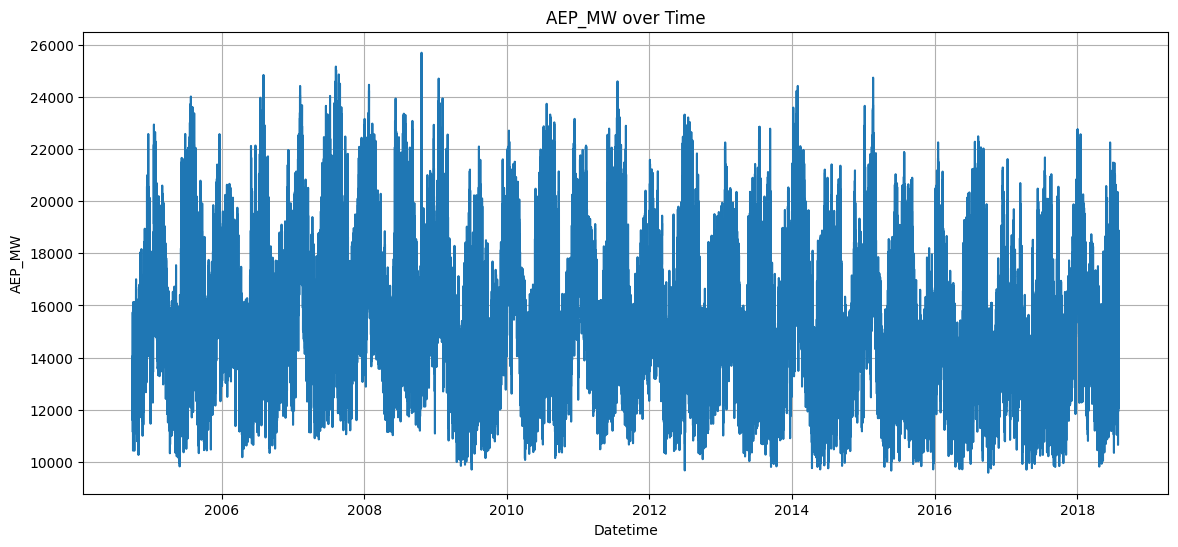

In [5]:
plt.figure(figsize=(14, 6))
plt.plot(data['Datetime'], data['AEP_MW'])
plt.title('AEP_MW over Time')
plt.xlabel('Datetime')
plt.ylabel('AEP_MW')
plt.grid(True)
plt.show()

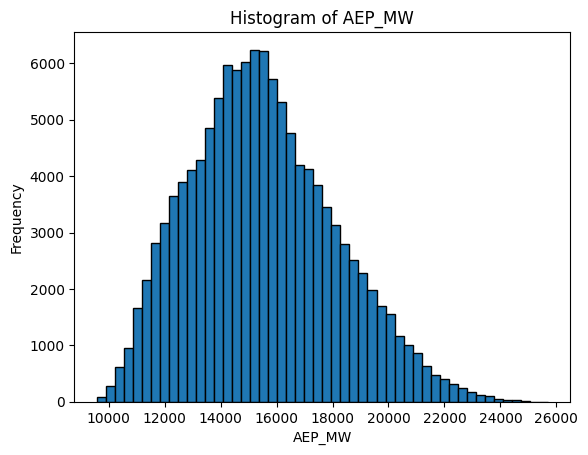

In [6]:
plt.Figure(figsize=(8, 5))
plt.hist(data['AEP_MW'], bins=50, edgecolor='black')
plt.title('Histogram of AEP_MW')
plt.xlabel('AEP_MW')
plt.ylabel('Frequency')
plt.show()

### Concept drift detection

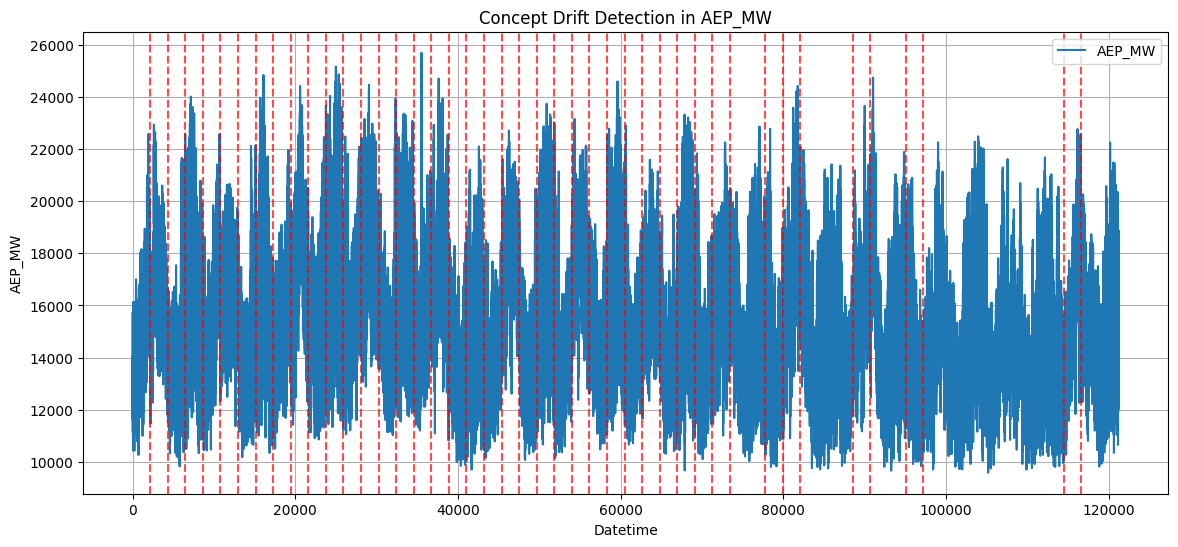

In [7]:
# Detect concept drift (with combined criteria)
drift_points = detect_seasonal_drift(data, 'AEP_MW', season_length=24*90, p_threshold=0.05, diff_threshold=0.05)  # 90-day seasons, stricter thresholds

# Plot (with vertical lines)
plot_concept_drift(data, 'AEP_MW', drift_points)

# Traditional ML

## Preprocessing data

### Feature engineering

In [8]:
df0 = data.copy()
df = pipeline(data) #Execution of the feature engineering pipeline
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121273 entries, 0 to 121272
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   Datetime  121273 non-null  datetime64[ns]
 1   AEP_MW    121273 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.9 MB


### Visualization of cyclical features over time

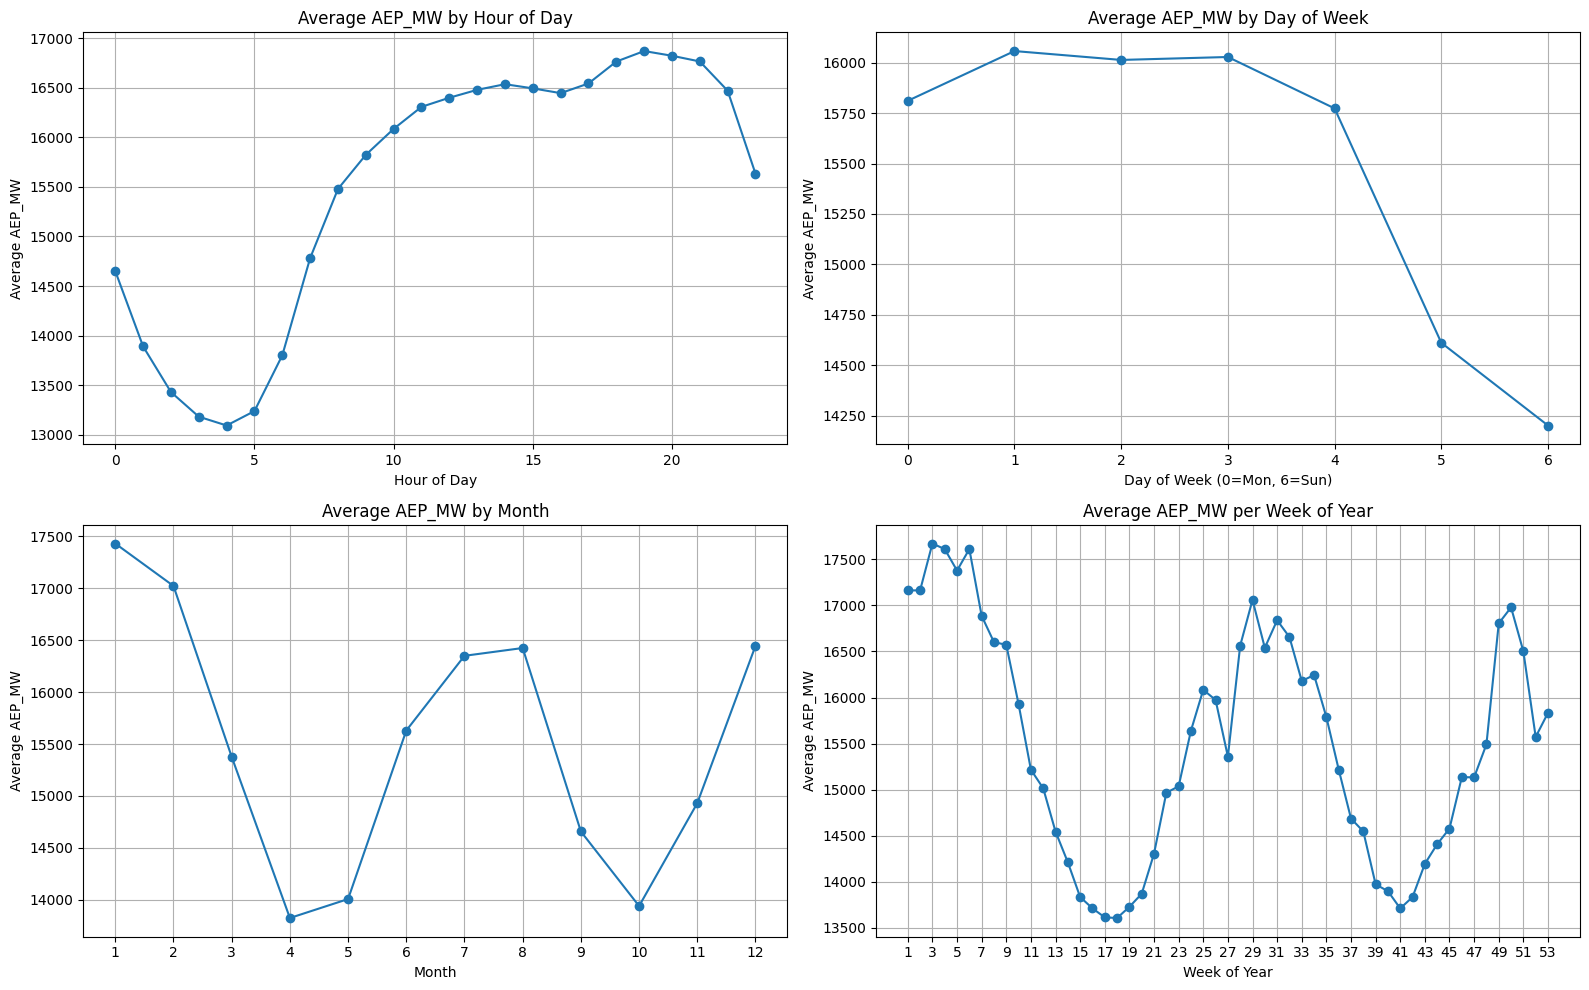

In [9]:
plt.figure(figsize=(16, 10))

# Average AEP_MW per Hour
plt.subplot(2, 2, 1)
df.groupby('Hour')['AEP_MW'].mean().plot(marker='o')
plt.title('Average AEP_MW by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average AEP_MW')
plt.grid(True)

# Average AEP_MW per Day of Week
plt.subplot(2, 2, 2)
df.groupby('DayOfWeek')['AEP_MW'].mean().plot(marker='o', xticks=range(7), rot=0)
plt.title('Average AEP_MW by Day of Week')
plt.xlabel('Day of Week (0=Mon, 6=Sun)')
plt.ylabel('Average AEP_MW')
plt.grid(True)

# Average AEP_MW per Month
plt.subplot(2, 2, 3)
df.groupby('Month')['AEP_MW'].mean().plot(marker='o', xticks=range(1, 13), rot=0)
plt.title('Average AEP_MW by Month')
plt.xlabel('Month')
plt.ylabel('Average AEP_MW')
plt.grid(True)

#Average AEP_MW per WeekOfYear
plt.subplot(2,2,4)
df.groupby('WeekOfYear')['AEP_MW'].mean().plot(marker='o', xticks=range(1,54,2), rot=0) #Plot every two weeks to avoid crowded X axis
plt.title('Average AEP_MW per Week of Year')
plt.xlabel('Week of Year')
plt.ylabel('Average AEP_MW')
plt.grid(True)


plt.tight_layout()
plt.show()

### Correlation Heatmap

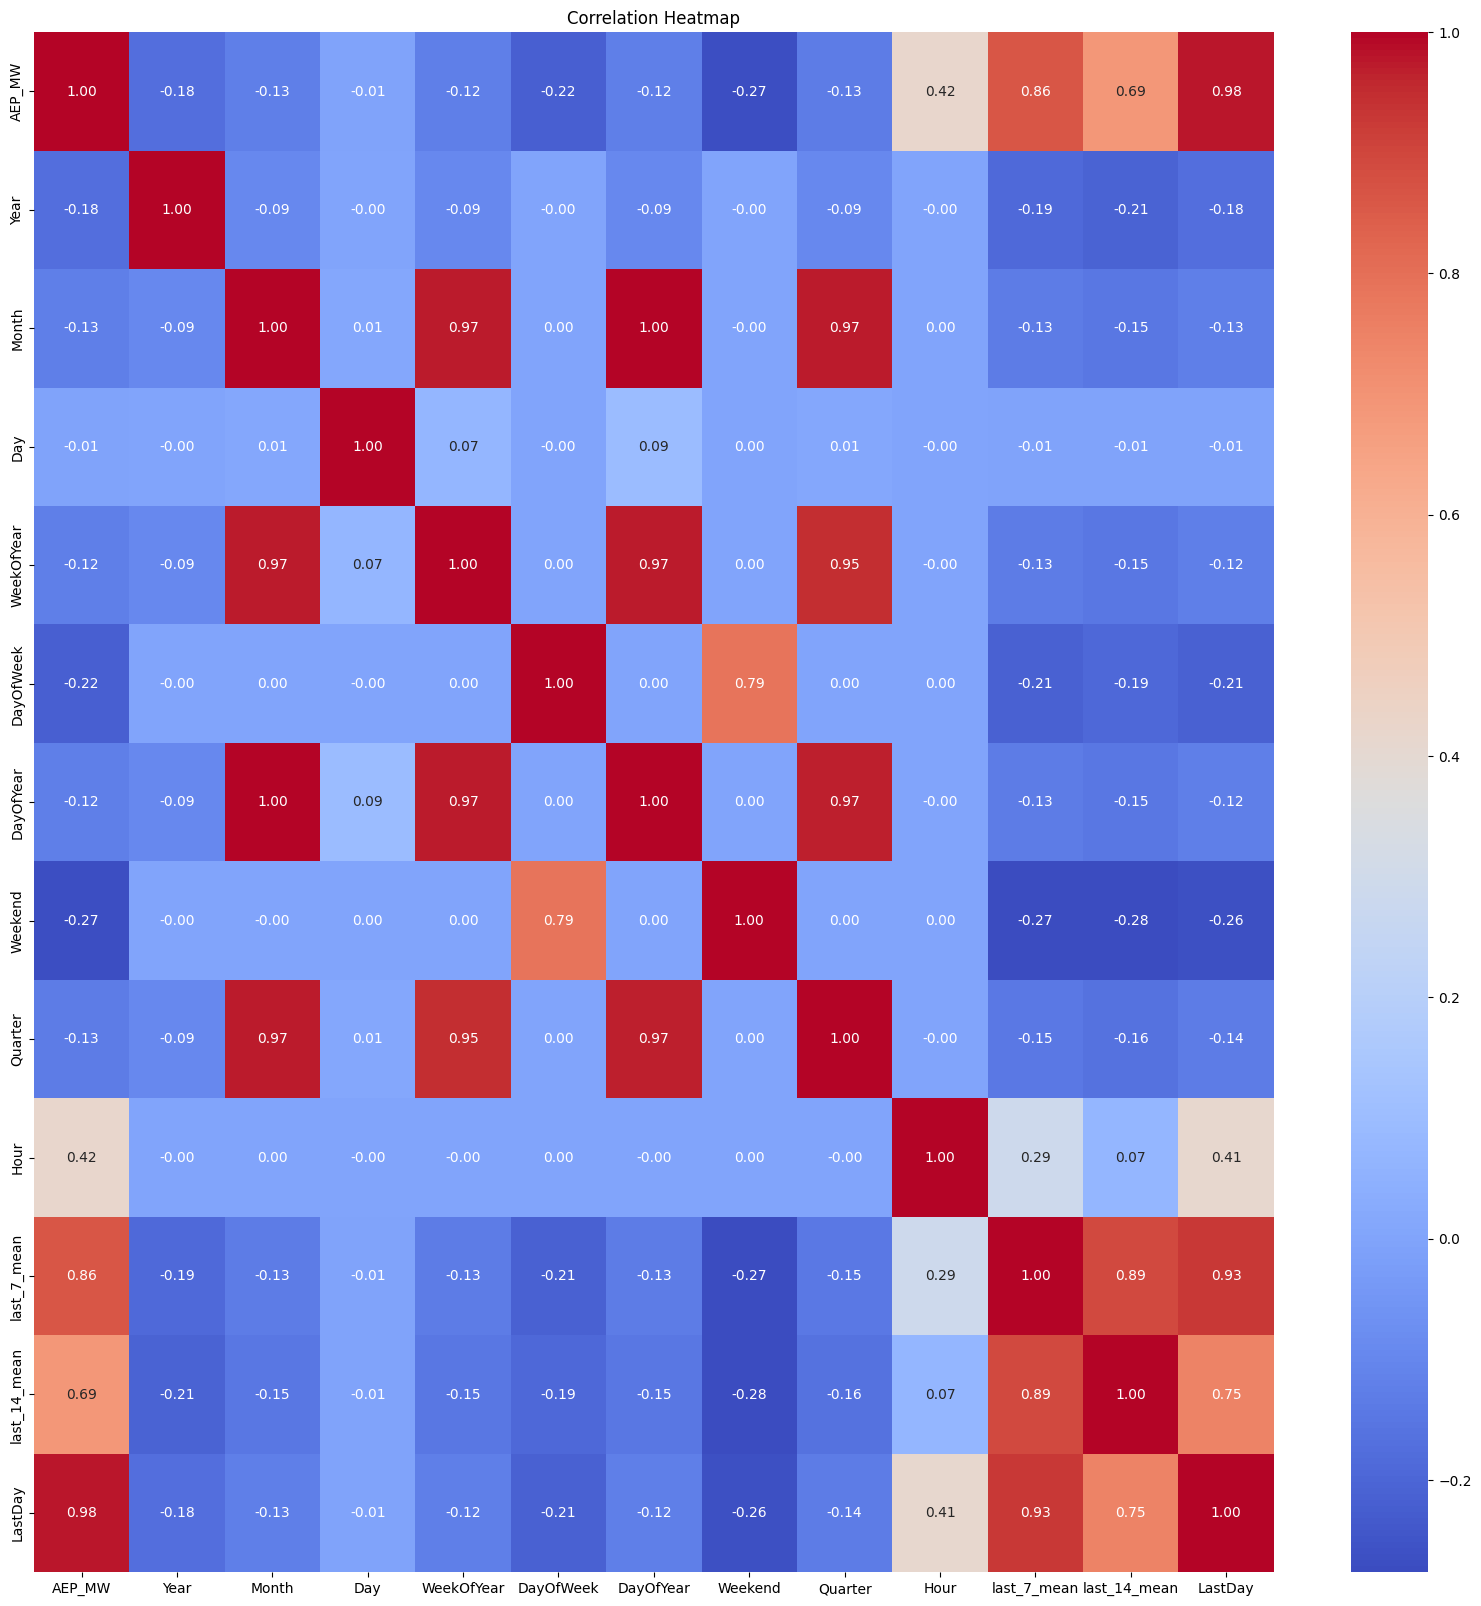

In [10]:
# Correlation heatmap
plt.figure(figsize=(20, 20))
corr = df.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

### Feature and Target

In [11]:
# --- Feature and Target ---
X = df.drop(['Datetime', 'Date', 'AEP_MW'], axis=1)
y = df['AEP_MW']

### Scaling and Time Series Split

In [12]:
# --- Scaling (Fit on initial chunk, then just transform)---
scaler = StandardScaler()
initial_chunk_size = int(len(df) * 0.7) #Fit on the same "train" data as before
scaler.fit(X[:initial_chunk_size])
X_scaled = scaler.transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns) #convert to df

# --- TimeSeriesSplit ---
n_splits = 5  # Number of folds.  5 is a common choice.
tscv = TimeSeriesSplit(n_splits=n_splits)

## Traditional modelling

In [13]:
# --- Model Initialization ---
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'KNN': KNeighborsRegressor()
}

### Hyperparameter Tuning

In [14]:
# --- Hyperparameter Grids ---
param_grids = {
    'Linear Regression': {
        'fit_intercept': [True, False]
    },
    'Random Forest': {
        'n_estimators': [50, 100],  
        'max_depth': [5, 10],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    },
    'KNN': {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance'],
        'p': [1, 2]  # 1: Manhattan distance, 2: Euclidean distance
    }
}

### Cross-validation with Grid-SearchCV

In [15]:
# Store results (including best hyperparameters)
all_results = {name: [] for name in models}

# --- Cross-Validation Loop with GridSearchCV ---
total_iterations = n_splits * len(models) #Folds * models
with tqdm.tqdm(total=total_iterations, desc="Cross-Validation with Tuning") as pbar:
    for train_index, test_index in tscv.split(X_scaled):
        X_train, X_test = X_scaled.iloc[train_index], X_scaled.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        for model_name, model in models.items():
            # Create GridSearchCV object
            grid_search = GridSearchCV(
                estimator=model,
                param_grid=param_grids[model_name],
                scoring='neg_root_mean_squared_error',  # Use negative RMSE for maximization
                cv=3,  # Inner cross-validation (within the training set)
                n_jobs=-1, 
                verbose=0  
            )

            # Fit GridSearchCV (finds the best hyperparameters)
            grid_search.fit(X_train, y_train)

            # Get the best model (with the best hyperparameters)
            best_model = grid_search.best_estimator_

            # Evaluate the best model on the test set
            y_pred = best_model.predict(X_test)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            mae = mean_absolute_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)

            # Store results (including best hyperparameters)
            all_results[model_name].append({
                'rmse': rmse,
                'mae': mae,
                'r2': r2,
                'best_params': grid_search.best_params_  # Store best hyperparameters
            })
            pbar.update(1)

# --- Aggregate Results ---
final_results = {}
for model_name, fold_results in all_results.items():
    df = pd.DataFrame(fold_results)
    final_results[model_name] = {
        'mean_rmse': df['rmse'].mean(),
        'mean_mae': df['mae'].mean(),
        'mean_r2': df['r2'].mean(),
        'std_rmse': df['rmse'].std(),
        'std_mae': df['mae'].std(),
        'std_r2': df['r2'].std(),
        'best_params': df['best_params'].iloc[df['rmse'].idxmin()] # Best params overall
    }

# --- Display Results ---
final_results_df = pd.DataFrame(final_results).T
display(final_results_df)

# --- Find Best Model (based on mean CV RMSE) ---
best_model_name = min(final_results, key=lambda k: final_results[k]['mean_rmse'])
print(f"\nBest model (based on mean CV RMSE): {best_model_name}")


Cross-Validation with Tuning:  13%|█▎        | 2/15 [02:37<19:39, 90.73s/it]c:\Users\User\OneDrive\Escritorio\Master Santiago\ML2\ML2_Practice\.venv\lib\site-packages\numpy\ma\core.py:2892: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
Cross-Validation with Tuning: 100%|██████████| 15/15 [32:46<00:00, 131.08s/it]


,mean_rmse,mean_mae,mean_r2,std_rmse,std_mae,std_r2,best_params
Linear Regression,425.749514,319.24065,0.971747,35.493397,23.557633,0.004495,{'fit_intercept': True}
Random Forest,272.622289,199.048715,0.988423,18.24808,7.366629,0.001526,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_..."
KNN,515.89829,394.963577,0.958507,72.284027,51.718372,0.009695,"{'n_neighbors': 7, 'p': 1, 'weights': 'distance'}"



Best model (based on mean CV RMSE): Random Forest


### Final Evaluation on Held-Out Test Set


In [16]:
# --- Final Evaluation on Held-Out Test Set ---
final_train_size = 0.8
final_train_end = int(len(df) * final_train_size)
X_final_train = X_scaled[:final_train_end]
y_final_train = y[:final_train_end]
X_final_test = X_scaled[final_train_end:]
y_final_test = y[final_train_end:]

# --- Fit Best Model on the Final Training Set ---
best_model = models[best_model_name].set_params(**final_results[best_model_name]['best_params'])
best_model.fit(X_final_train, y_final_train)

# --- Evaluate Best Model on the Held-Out Test Set ---
y_final_pred = best_model.predict(X_final_test)

final_rmse = np.sqrt(mean_squared_error(y_final_test, y_final_pred))
final_mae = mean_absolute_error(y_final_test, y_final_pred)
final_r2 = r2_score(y_final_test, y_final_pred)

final_evaluation_df = pd.DataFrame({
    'Metric': ['RMSE', 'MAE', 'R2'],
    'Value': [final_rmse, final_mae, final_r2]
})

print(f"\n--- Final Evaluation on Held-Out Test Set ({best_model_name}) ---")
display(final_evaluation_df)


--- Final Evaluation on Held-Out Test Set (Random Forest) ---


,Metric,Value
0,RMSE,4506.802477
1,MAE,3771.273700
2,R2,-2.024752


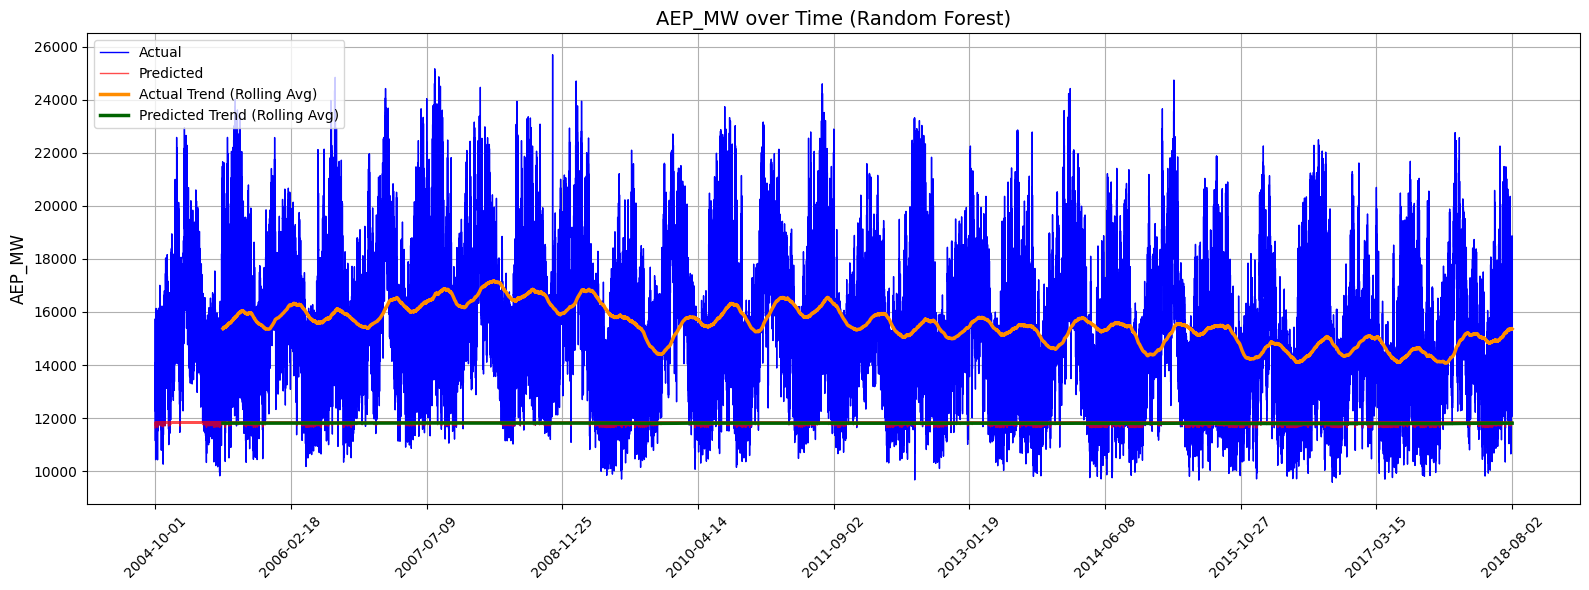

In [17]:
#Plot the final result
plot_time_series_predictions(best_model, X_final_test, y_final_test, title=f'AEP_MW over Time ({best_model_name})')

# Streaming ML

## Preprocessing data

The preprocession of the data is one of the key parts of every machine learning based solution and stream learning is not the execption. Using the river library, two preprocessing pipelines have been created. They are the same except that one applies standarization and the other does not. Among the three models that we are going to use later one, one needs the standarization of the input variables (Hoeffing Tree Regressor) while the other two do not (Bayesian Linear Regressor and kNN). 

The initial input variable that the stream provides is just the date and time of the instance. Applying feature engineering, we obtain the following variables:
- Year
- Month
- Week of the year
- Day of week
- Day of year
- Weekend
- Quarter
- Hour
- The true output of the previous instance

Also, after obtaining these features, we discard the initial date-time variable. Moreover, using the river library, we obtain the mean of the past 7 and 14 true output values of the stream.

In [4]:
preprocessing_pipeline_no_standarization = compose.Pipeline(
    ('features', compose.TransformerUnion(
        ('date_features', compose.FuncTransformer(divide_date)),
        ('last_7_mean', feature_extraction.TargetAgg(by=None, how=utils.Rolling(stats.Mean(),7),target_name="last_7_mean")),
        ('last_14_mean', feature_extraction.TargetAgg(by=None, how=utils.Rolling(stats.Mean(),14), target_name="last_14_mean"))
    )),
    ('drop_non_features', compose.Discard('Datetime')),
)

preprocessing_pipeline_standarization = compose.Pipeline(
    ('features', compose.TransformerUnion(
        ('date_features', compose.FuncTransformer(divide_date)),
        ('last_7_mean', feature_extraction.TargetAgg(by=None, how=utils.Rolling(stats.Mean(),7),target_name="last_7_mean")),
        ('last_14_mean', feature_extraction.TargetAgg(by=None, how=utils.Rolling(stats.Mean(),14), target_name="last_14_mean"))
    )),
    ('drop_non_features', compose.Discard('Datetime')),
    ('scale', preprocessing.StandardScaler()),   
)

## Stream models

We build and compare three stream leraning models. We concatenate them with the proper preprocessing pipeline according to their requirements, for example, the Bayesian Linear Rregression Model does not need standarization of the inputs.

### Bayesian Linear Regression Model

As mentioned above, the Bayesian Linear Regression model does not need to standarize the inputs. Also, it is somewhat insensitive to its hyperparameters, which is an attractive feature.

To train it, we concatente to it the preprocessing pipeline that does not perform standarization and measure its RMSE. We compare it to a base model that just returns the true value of the previous instance of the stream, trying to prove that the model is better than just repeating the immediate past.

In [5]:
# Creating the model
bayesian = copy.deepcopy(preprocessing_pipeline_no_standarization) | ('lin_reg_bay', linear_model.BayesianLinearRegression())

# Training the model
rmse_bayesian, rmse_base, y_trues_bayesian, y_preds_bayesian, _ = train_model(model=bayesian, dataset_path="dataset/AEP_hourly.csv")
print("Bayesian RMSE: ", rmse_bayesian)
print("Base RMSE: ", rmse_base)

Procesando: 0it [00:00, ?it/s]

Procesando: 121273it [03:01, 667.93it/s]

Bayesian RMSE:  RMSE: 427.653967
Base RMSE:  RMSE: 566.219412


Here we plot a comparison of the true values of the stream and the predicted values, to have a visual way of evaluating the performance of the model

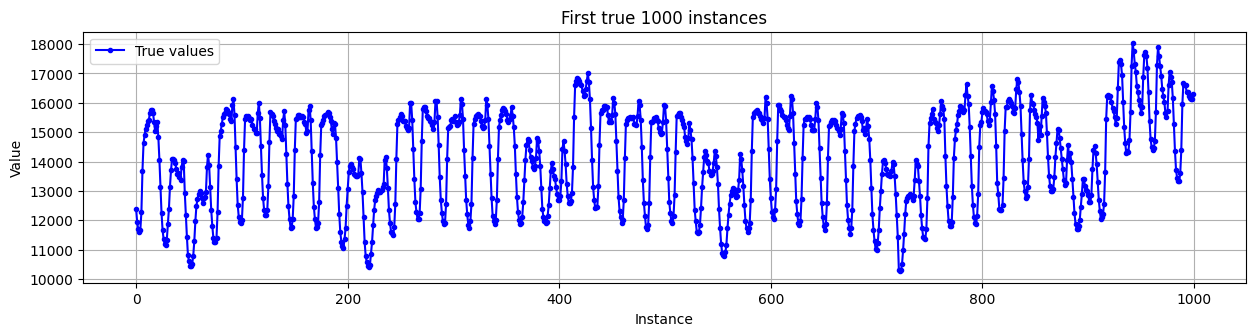

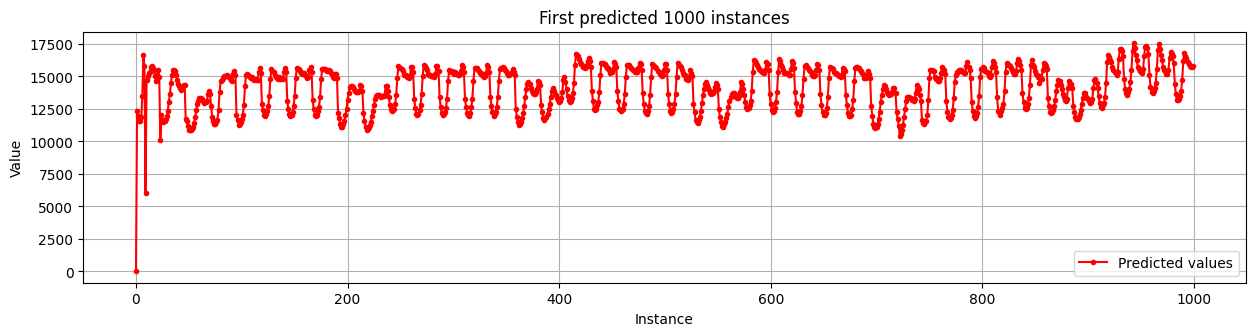

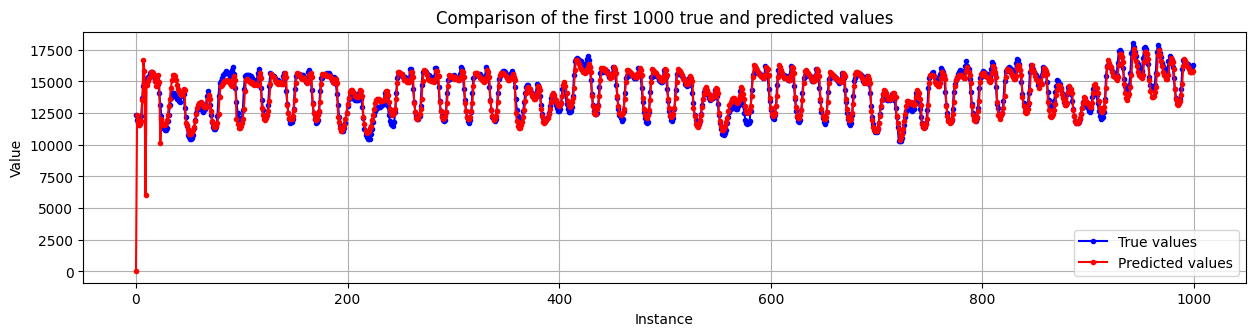

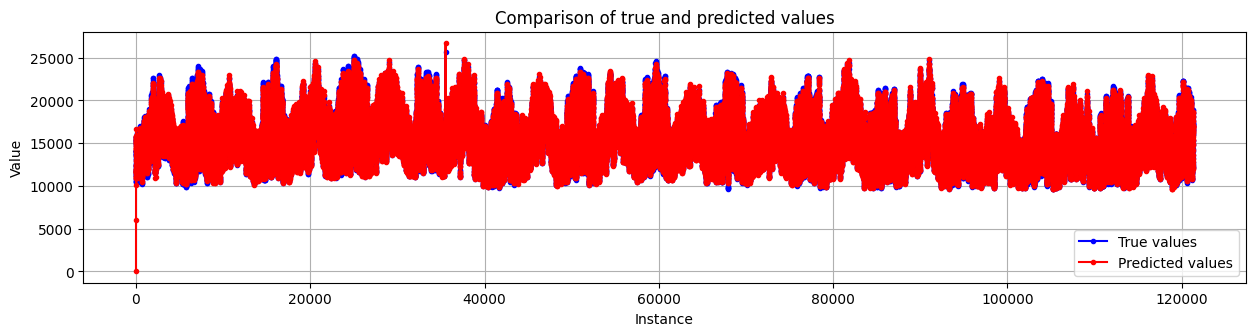

In [21]:
plot_results(y_trues=y_trues_bayesian, y_preds=y_preds_bayesian)

### Hoeffing Tree Regressor

We also make use of a Hoeffing treen regressor, which is a model specifically designed for incremental learning, that can also deal with the concept drift of the data stream.

In [9]:
# Creating the model
hoef = copy.deepcopy(preprocessing_pipeline_standarization) | ('lin_reg_hoef', HoeffdingTreeRegressor(grace_period=250))

# Training the model
rmse_hoef, rmse_base, y_trues_hoef, y_pred_hoef, _ = train_model(model=hoef, dataset_path="dataset/AEP_hourly.csv")
print("Hoeffing Tree RMSE: ", rmse_hoef)
print("Base RMSE: ", rmse_base)

Procesando: 121273it [03:14, 625.00it/s]

Hoeffing Tree RMSE:  RMSE: 699.476899
Base RMSE:  RMSE: 566.219412


As in the previous model, we plot the true values and the predicted values to evaluate visually the model

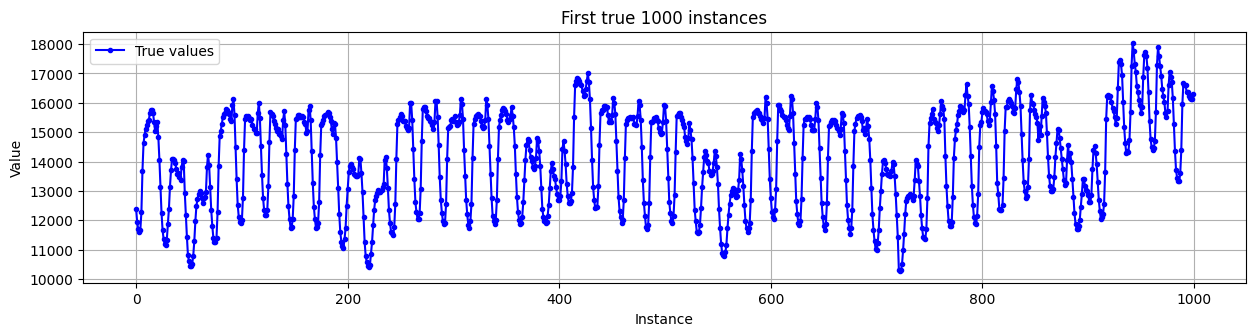

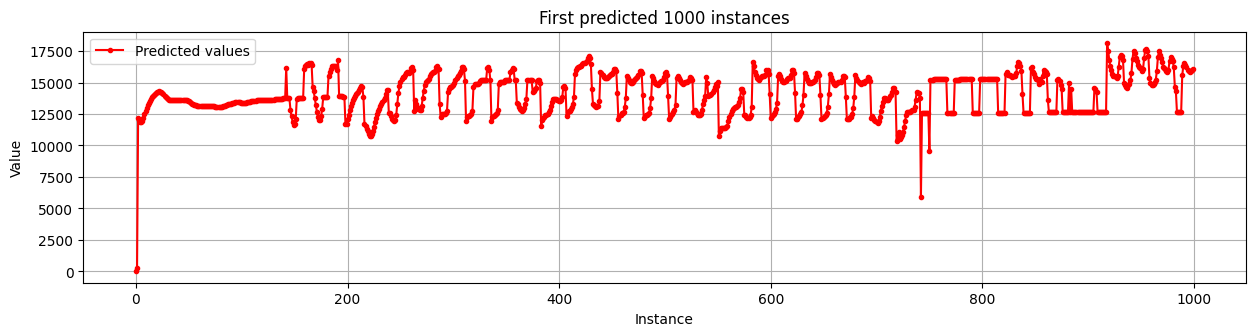

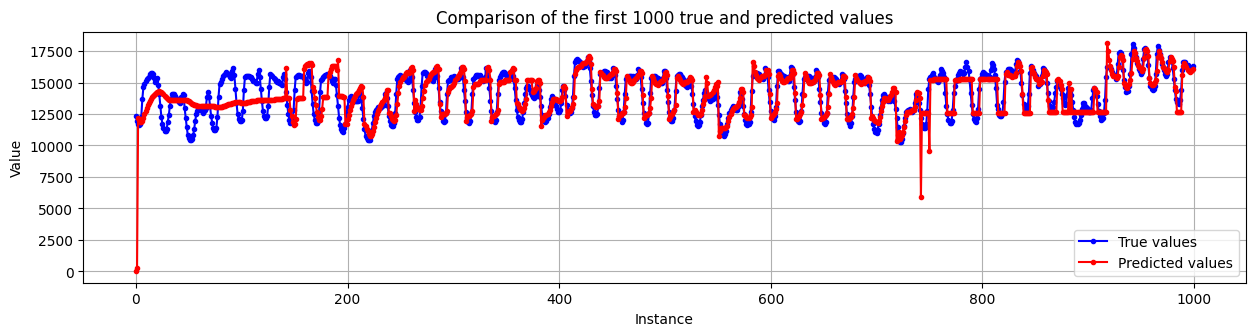

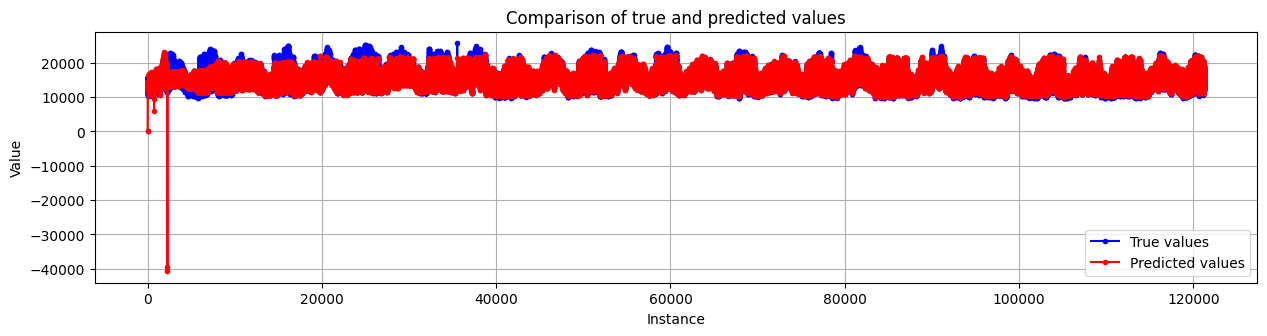

In [19]:
plot_results(y_trues=y_trues_hoef, y_preds=y_pred_hoef)

### KNN

Finally, we opted to use a "lazy" model to compare its performance with the other models. Since this one depends on the calculation of distances, we opted for not using standarization. An interesting fact to remark is that kNN takes much more time to train than previous models due to its nature.

In [ ]:
# Creating the model
knn = copy.deepcopy(preprocessing_pipeline_no_standarization) | ('lin_reg_knn', neighbors.KNNRegressor())

# Training the model
rmse_knn, rmse_base, y_trues_knn, y_pred_knn, _ = train_model(knn, dataset_path="dataset/AEP_hourly.csv")
print("KNN RMSE: ", rmse_knn)
print("Base RMSE: ", rmse_base)

Procesando: 54it [00:00, 531.46it/s]

Procesando: 121273it [30:40, 65.89it/s] 

Bayesian RMSE:  RMSE: 438.875933
Base RMSE:  RMSE: 566.219412


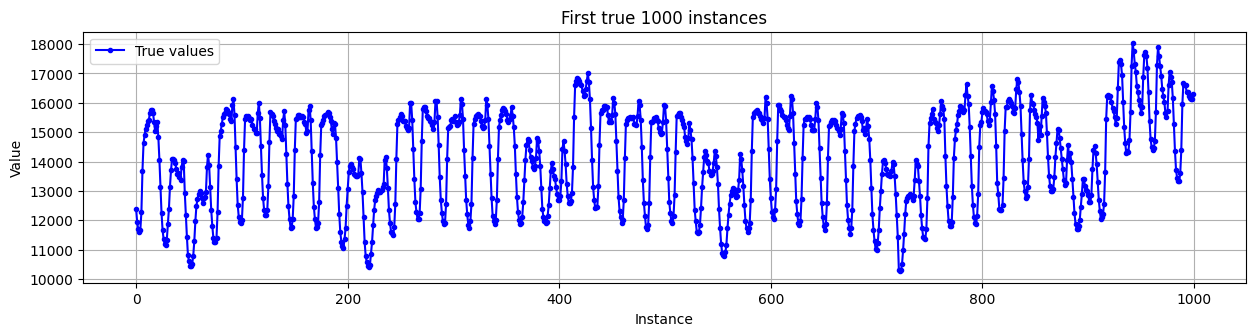

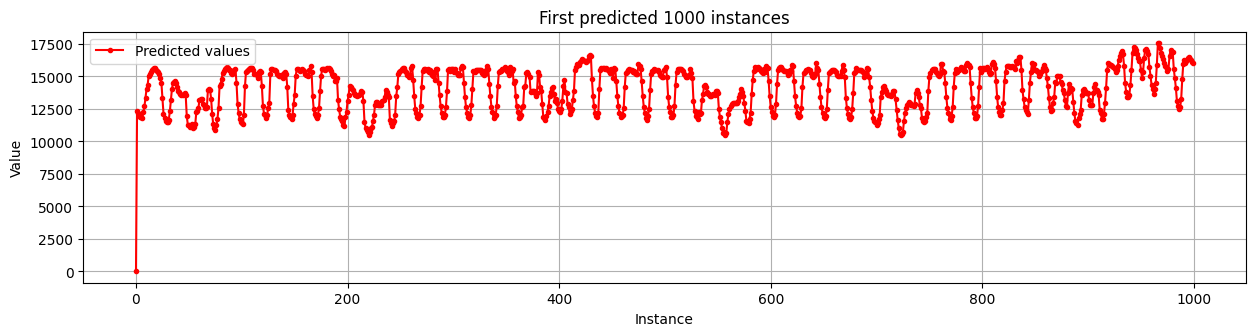

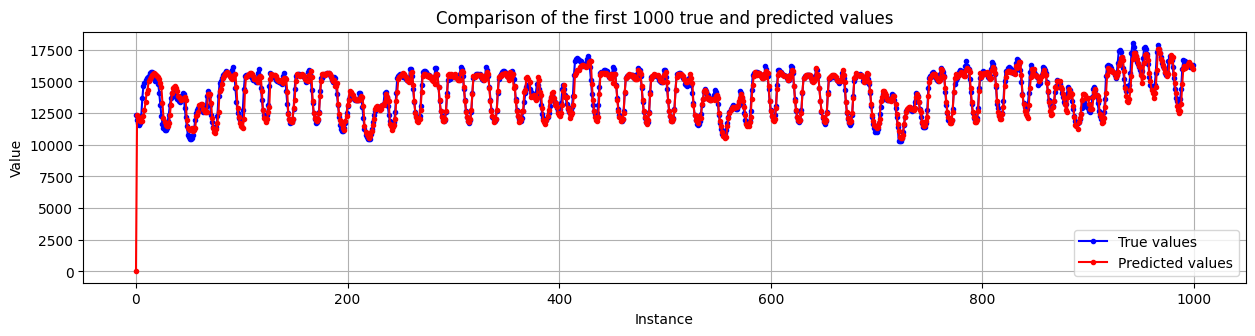

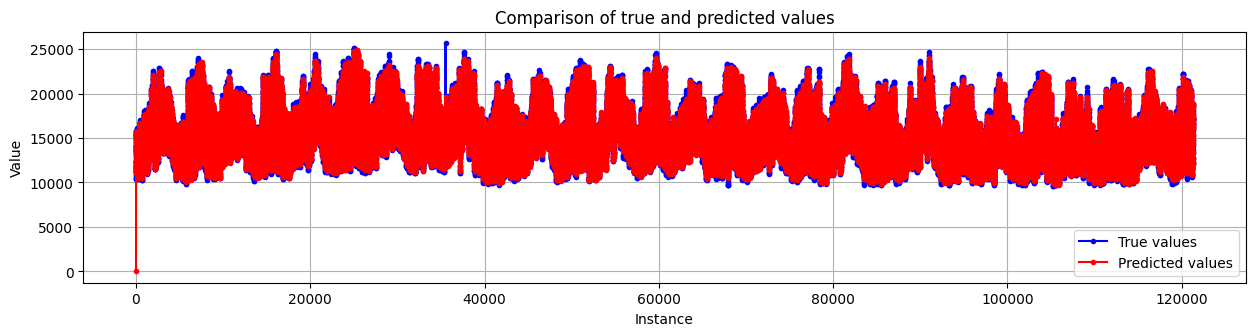

In [21]:
plot_results(y_trues=y_trues_knn, y_preds=y_pred_knn)

## Concept Drift

In online machine learning, it is assumed that data can change over time. When building machine learning models, we assume data has a probability distribution, which is usually fixed, i.e., stationary. Changes in the data distribution give rise to the phenomenon called **Concept drift**. Such drifts can be either virtual or real. In virtual drifts, only the distribution of the features, changes, whereas the relationship between features and the target, remains unchanged. River implements different concept drift detectors to determine when do they occur in the data stream.

In this project, we may be affected by several types of drifts. Since we are trying to predict the energy consumption of each hour, we may suffer drifts that represent changes in the data distribution of the days of the week, the weeks of the month, the months of the year or the seasons/quartes of the year. Therefore, we will try to configure the detectors so they can focus on different types of drifts. 

### ADWIN

ADWIN (ADaptive WINdowing) is a popular drift detection method with mathematical guarantees. ADWIN efficiently keeps a variable-length window of recent items; such that it holds that there has no been change in the data distribution. This window is further divided into two sub-windows used to determine if a change has happened. ADWIN compares the average of both windows to confirm that they correspond to the same distribution. Concept drift is detected if the distribution equality no longer holds.

The way that we defined the parameters of the ADWIN detector allows it to detect the drifts that occur through the course of 14 weeks. It seems to detect drifts after 9 weeks, which may be cuased by a change of the season of the year.

Procesando: 0it [00:00, ?it/s]

Procesando: 167it [00:00, 337.33it/s]

Change detected at index 127


Procesando: 1737it [00:03, 476.91it/s]

Change detected at index 1631


Procesando: 1883it [00:04, 453.23it/s]

Change detected at index 1791


Procesando: 2128it [00:04, 480.61it/s]

Change detected at index 2047


Procesando: 2324it [00:05, 469.79it/s]

Change detected at index 2239


Procesando: 2352it [00:05, 444.09it/s]


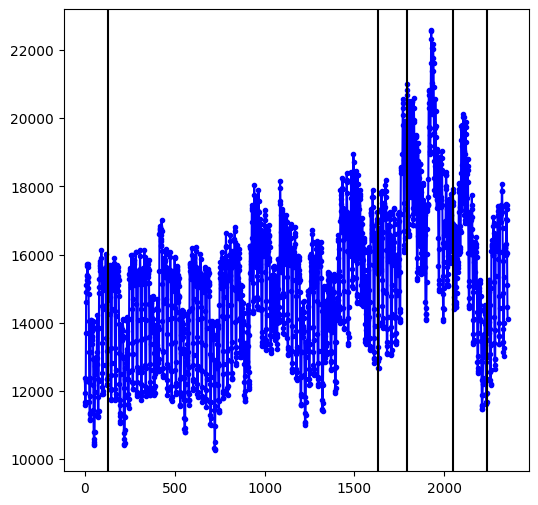

In [12]:
model = compose.Pipeline(
    ('features', compose.TransformerUnion(
        ('date_features', compose.FuncTransformer(divide_date)),
        ('last_7_mean', feature_extraction.TargetAgg(by=None, how=utils.Rolling(stats.Mean(),7),target_name="last_7_mean")),
        ('last_14_mean', feature_extraction.TargetAgg(by=None, how=utils.Rolling(stats.Mean(),14), target_name="last_14_mean"))
    )),
    ('drop_non_features', compose.Discard('Datetime')),
    ('lin_reg', linear_model.BayesianLinearRegression())
)

drift_detector_adwin = ADWIN(delta=0.1)

_, _, y_trues, _, drifts = train_model(model=model, dataset_path="dataset/AEP_hourly.csv", drift_detector=drift_detector_adwin, stop_point=(14*168))

plot_concept_drifts(y_trues=y_trues, drifts=drifts)

### PageHinkley

PageHinkley works by computing the observed values and their mean up to the current moment. This detector implements the CUSUM control chart for detecting changes. This implementation also supports the two-sided Page-Hinkley test to detect increasing and decreasing changes in the mean of the input values.

We configure it so it can detect the variations of the data distribution of the days of the week, through a period of 30 days. As it can be seen below, it marks a drift almost every day, which indicates that each day is different. This time-window for detections is low and might have little to no impact for the model, but it is worth noting.

Procesando: 28it [00:00, 273.81it/s]

Procesando: 56it [00:00, 252.20it/s]

Change detected at index 29
Change detected at index 59


Procesando: 180it [00:00, 299.28it/s]

Change detected at index 92
Change detected at index 122
Change detected at index 161


Procesando: 247it [00:00, 315.07it/s]

Change detected at index 193
Change detected at index 240
Change detected at index 271


Procesando: 342it [00:01, 262.30it/s]

Change detected at index 310


Procesando: 426it [00:01, 268.23it/s]

Change detected at index 397
Change detected at index 430


Procesando: 511it [00:01, 275.51it/s]

Change detected at index 463
Change detected at index 502


Procesando: 596it [00:02, 272.29it/s]

Change detected at index 540
Change detected at index 575


Procesando: 652it [00:02, 267.72it/s]

Change detected at index 616
Change detected at index 653


Procesando: 720it [00:02, 282.35it/s]

Change detected at index 686


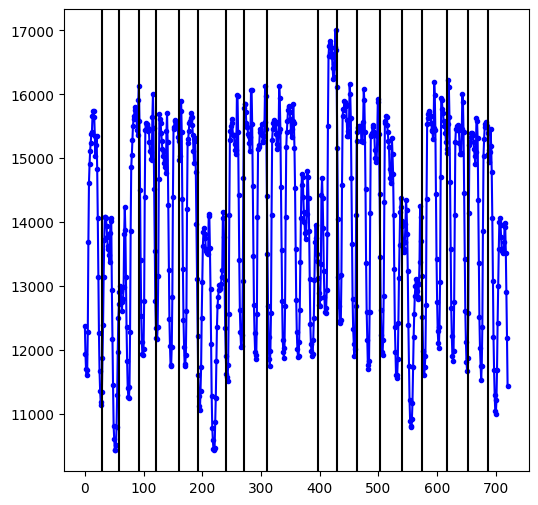

In [15]:
model = compose.Pipeline(
    ('features', compose.TransformerUnion(
        ('date_features', compose.FuncTransformer(divide_date)),
        ('last_7_mean', feature_extraction.TargetAgg(by=None, how=utils.Rolling(stats.Mean(),7),target_name="last_7_mean")),
        ('last_14_mean', feature_extraction.TargetAgg(by=None, how=utils.Rolling(stats.Mean(),14), target_name="last_14_mean"))
    )),
    ('drop_non_features', compose.Discard('Datetime')),
    ('lin_reg', linear_model.BayesianLinearRegression())
)

drift_detector_hinkley = PageHinkley(delta=0.000001, threshold=2000)

_, _, y_trues, _, drifts = train_model(model=model, dataset_path="dataset/AEP_hourly.csv", drift_detector=drift_detector_hinkley, stop_point=(30*24))

plot_concept_drifts(y_trues=y_trues, drifts=drifts)

### KSWIN

KSWIN detects changes by comparing the distribution of recent data with an older reference window. It uses a significance threshold (alpha) to adjust sensitivity to changes.

We configure it so it can detect the drifts between the months of the year during a whole year time period. As it can be seen below, this detector is able to detect changes that occur through a group of months, remarking the differences of the different periods of the year.

Procesando: 398it [00:01, 341.69it/s]

Change detected at index 317


Procesando: 1545it [00:06, 348.58it/s]

Change detected at index 1456


Procesando: 1894it [00:07, 328.86it/s]

Change detected at index 1783


Procesando: 2023it [00:08, 373.50it/s]

Change detected at index 1930


Procesando: 2351it [00:09, 335.57it/s]

Change detected at index 2235


Procesando: 5685it [00:25, 354.43it/s]

Change detected at index 5581


Procesando: 6018it [00:27, 331.92it/s]

Change detected at index 5940


Procesando: 7264it [00:33, 309.97it/s]

Change detected at index 7198


Procesando: 8640it [00:39, 217.71it/s]


Change detected at index 8605


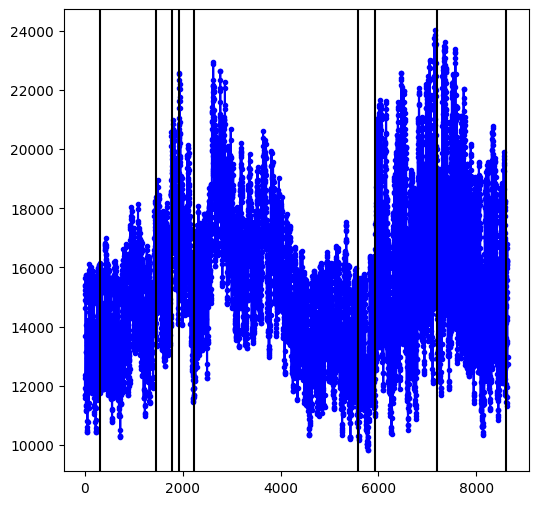

In [16]:
model = compose.Pipeline(
    ('features', compose.TransformerUnion(
        ('date_features', compose.FuncTransformer(divide_date)),
        ('last_7_mean', feature_extraction.TargetAgg(by=None, how=utils.Rolling(stats.Mean(),7),target_name="last_7_mean")),
        ('last_14_mean', feature_extraction.TargetAgg(by=None, how=utils.Rolling(stats.Mean(),14), target_name="last_14_mean"))
    )),
    ('drop_non_features', compose.Discard('Datetime')),
    ('lin_reg', linear_model.BayesianLinearRegression())
)

drift_detector_kswin = KSWIN(alpha=0.0008)

_, _, y_trues, _, drifts = train_model(model=model, dataset_path="dataset/AEP_hourly.csv", drift_detector=drift_detector_kswin, stop_point=(12*720))

plot_concept_drifts(y_trues=y_trues, drifts=drifts)